# Modeling

In [239]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as scp
from   matplotlib  import pyplot   as plt
from   matplotlib  import patches  as pat

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn import metrics

plt.style.use('seaborn-whitegrid')

In [2]:
data = pd.read_csv('Output.csv')

In [5]:
data = data.drop(columns='Unnamed: 0')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         1210 non-null   float64
 1   beds          1210 non-null   int64  
 2   baths         1210 non-null   int64  
 3   size          1210 non-null   int64  
 4   address       1210 non-null   object 
 5   city          1210 non-null   object 
 6   state         1210 non-null   object 
 7   zipcode       1210 non-null   int64  
 8   region        1210 non-null   object 
 9   pricepersqft  1210 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 94.7+ KB


In [7]:
data.sample(3)

,price,beds,baths,size,address,city,state,zipcode,region,pricepersqft
391,1415000.0,3,2,2800,2040 North Damen Avenue 3,Chicago,IL,60647,north,110.719875
750,1050000.0,2,2,1120,6533 Seaview Avenue NW 411A,Seattle,WA,98117,west,82.159624
226,6550.0,5,3,2760,1625 Chesterwood Cove,Austin,TX,78746,south,0.512520


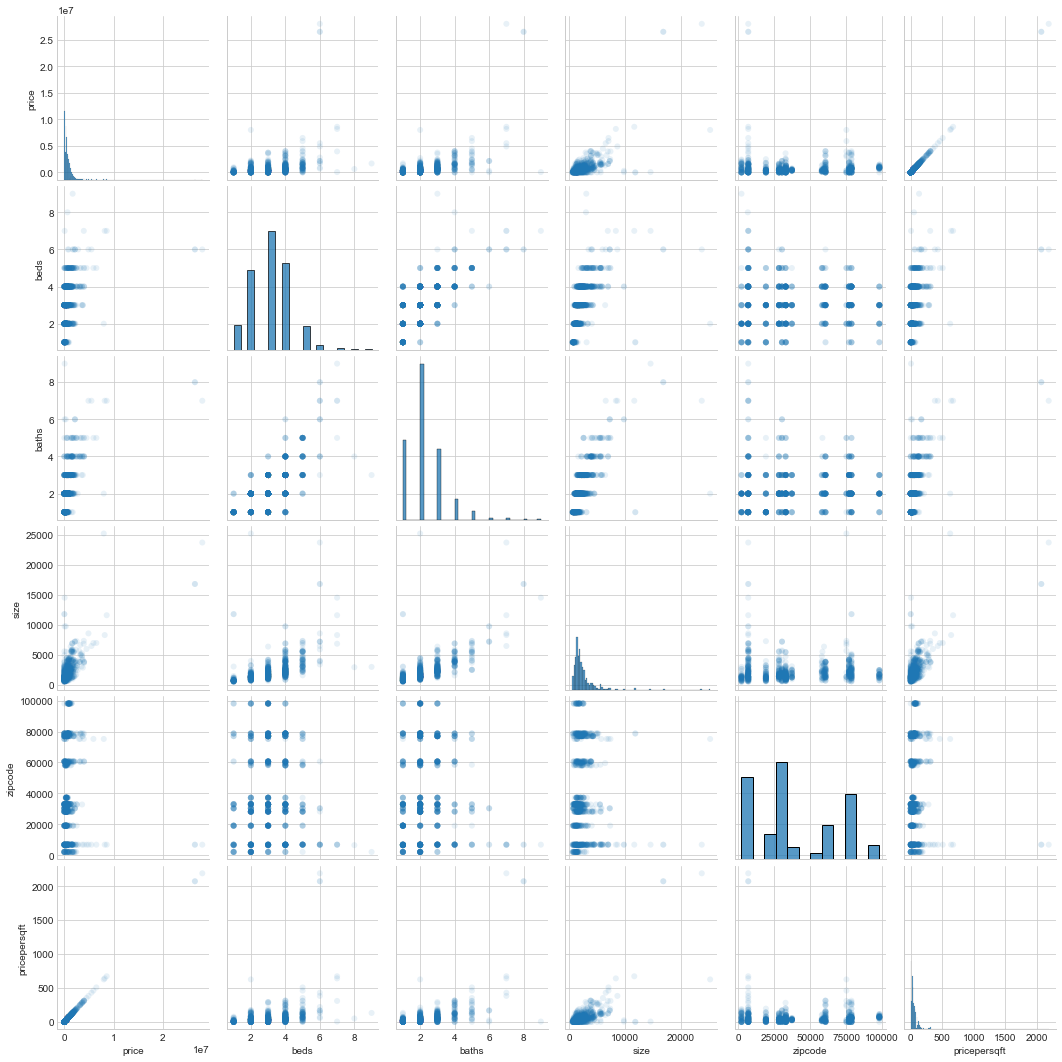

In [30]:
sns.pairplot(data[:1000], plot_kws=dict(alpha=.1, edgecolor='none'))

In [9]:
# Split into train, val, and test
X, X_test, y, y_test = train_test_split(data[['beds','baths','size']], 
                                        data['price'], test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [10]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.6417997304120356

In [11]:
# Score on validation set
lr.score(X_val,y_val)

-1.3368507616100418

Train score is bigger than val score, so there is overfitting and outliers. Let's see if polynomial regression can do better.

In [13]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

0.8430923380521589

In [14]:
# Score on validation set
lr_poly.score(X_val_poly, y_val)

0.204635190936037

In [17]:
lr_poly.coef_

array([ 0.00000000e+00,  2.21390136e+05,  6.89911866e+05, -9.58386645e+02,
        6.24595739e+03, -1.61926171e+05,  8.43942171e+01, -9.69418364e+04,
        2.49104946e+02,  7.85363993e-03])

This polynomial model gets a higher R2 score but seems to be still overfit. Let's try encoding to convert categorical data to numerical, and using them to a get a model that minimizes errors while keeping the model as simple as possible.

In [28]:
data.columns

Index(['price', 'beds', 'baths', 'size', 'address', 'city', 'state', 'zipcode',
       'region', 'pricepersqft'],
      dtype='object')

In [31]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

In [32]:
split_and_validate(X, y)


Validation R^2 score was: 0.39172091240342644
Feature coefficient results: 

beds : -268953.88
baths : 148928.08
size : 791.35


In [35]:
X2 = X.copy()

X2['bath2'] = X2['baths'] ** 2
X2['size2'] = X2['size'] ** 2


split_and_validate(X2, y)


Validation R^2 score was: 0.5285435933796477
Feature coefficient results: 

beds : 71685.10
baths : -395520.31
size : -426.29
bath2 : 168294.49
size2 : 0.06


they gave us an additional boost for R^2.

### feature engineering

In [38]:
X3 = X2.copy()


# division interaction
X3['bath/size'] = X3['baths'] / X3['size']

split_and_validate(X3, y)


Validation R^2 score was: 0.5233374684825993
Feature coefficient results: 

beds : -37865.32
baths : 277008.44
size : -926.01
bath2 : 134713.13
size2 : 0.08
bath/size : -1130317554.05


no improvment for R^2.

In [40]:
data['region'].value_counts()

east     447
south    422
west     219
north    122
Name: region, dtype: int64

In [44]:
pd.get_dummies(data['region']).sample(3)

,east,north,south,west
1130,0,0,0,1
1097,0,0,0,1
152,1,0,0,0


In [46]:
X4 = X2.copy()

X4['region'] = data['region']

split_and_validate(pd.get_dummies(X4), y)


Validation R^2 score was: 0.5323303893446267
Feature coefficient results: 

beds : 61925.08
baths : -381795.55
size : -430.44
bath2 : 168051.19
size2 : 0.06
region_east : -3561.12
region_north : 99837.48
region_south : -101075.52
region_west : 4799.16


I gained .01 improvement for R^2. Let's think about bringing in another categorical variable, States, from the original data.

In [47]:
state_counts = data.state.value_counts()
state_counts

TX    191
CT    187
CA    150
FL    137
NC     94
MA     90
PA     76
IL     67
GA     57
WA     43
TN     37
ND     33
OR     26
MT     22
Name: state, dtype: int64

In [54]:
other_states = list(state_counts[state_counts <= 50].index)

X5 = X4.copy()

X5['state'] = data['state'].replace(other_states, 'Other')

split_and_validate(pd.get_dummies(X5), y)


Validation R^2 score was: 0.5522057627202397
Feature coefficient results: 

beds : 90840.37
baths : -421085.01
size : -425.12
bath2 : 173672.66
size2 : 0.06
region_east : 13800.33
region_north : -171439.68
region_south : -157039.05
region_west : 314678.39
state_CA : -442370.48
state_CT : -56845.22
state_FL : 70908.03
state_GA : -342896.36
state_IL : 493299.29
state_MA : 295697.71
state_NC : -178950.82
state_Other : 12945.33
state_PA : -46101.34
state_TX : 194313.86


Now I have another ~.01 R^2 boost, though at the expense of adding a large number of feature columns!

Now, I am going to use the metis prepared function which creates features that capture where a feature value lies relative to the members of a category it belongs to. In particular, I'll calculate deviance of a row's feature value from the mean value of the category that row belongs to. This helps to capture information about a feature relative to the category's distribution, e.g. how nice a house is relative to other houses in its neighborhood or of its style.

In [50]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

And now let's use our feature generation code to add 2 new deviation features, and run a final benchmark.

In [60]:
X6 = X5.copy()

add_deviation_feature(X6, 'size', 'state')

split_and_validate(pd.get_dummies(X6), y)


Validation R^2 score was: 0.5508151426443806
Feature coefficient results: 

beds : 90316.43
baths : -433146.93
size : -452.27
bath2 : 175951.66
size2 : 0.06
size_Dev_state : 32954.44
region_east : 11981.58
region_north : -177520.60
region_south : -152812.96
region_west : 318351.97
state_CA : -441040.19
state_CT : -39029.11
state_FL : 57398.15
state_GA : -345436.65
state_IL : 506974.18
state_MA : 279591.49
state_NC : -173553.22
state_Other : 9857.63
state_PA : -55027.58
state_TX : 200265.29


Well it didn't help much!

### Trying more advance methods

In [152]:
df4 = pd.read_csv('output_2.csv')

In [153]:
df4 = df4.drop(columns = 'Unnamed: 0')

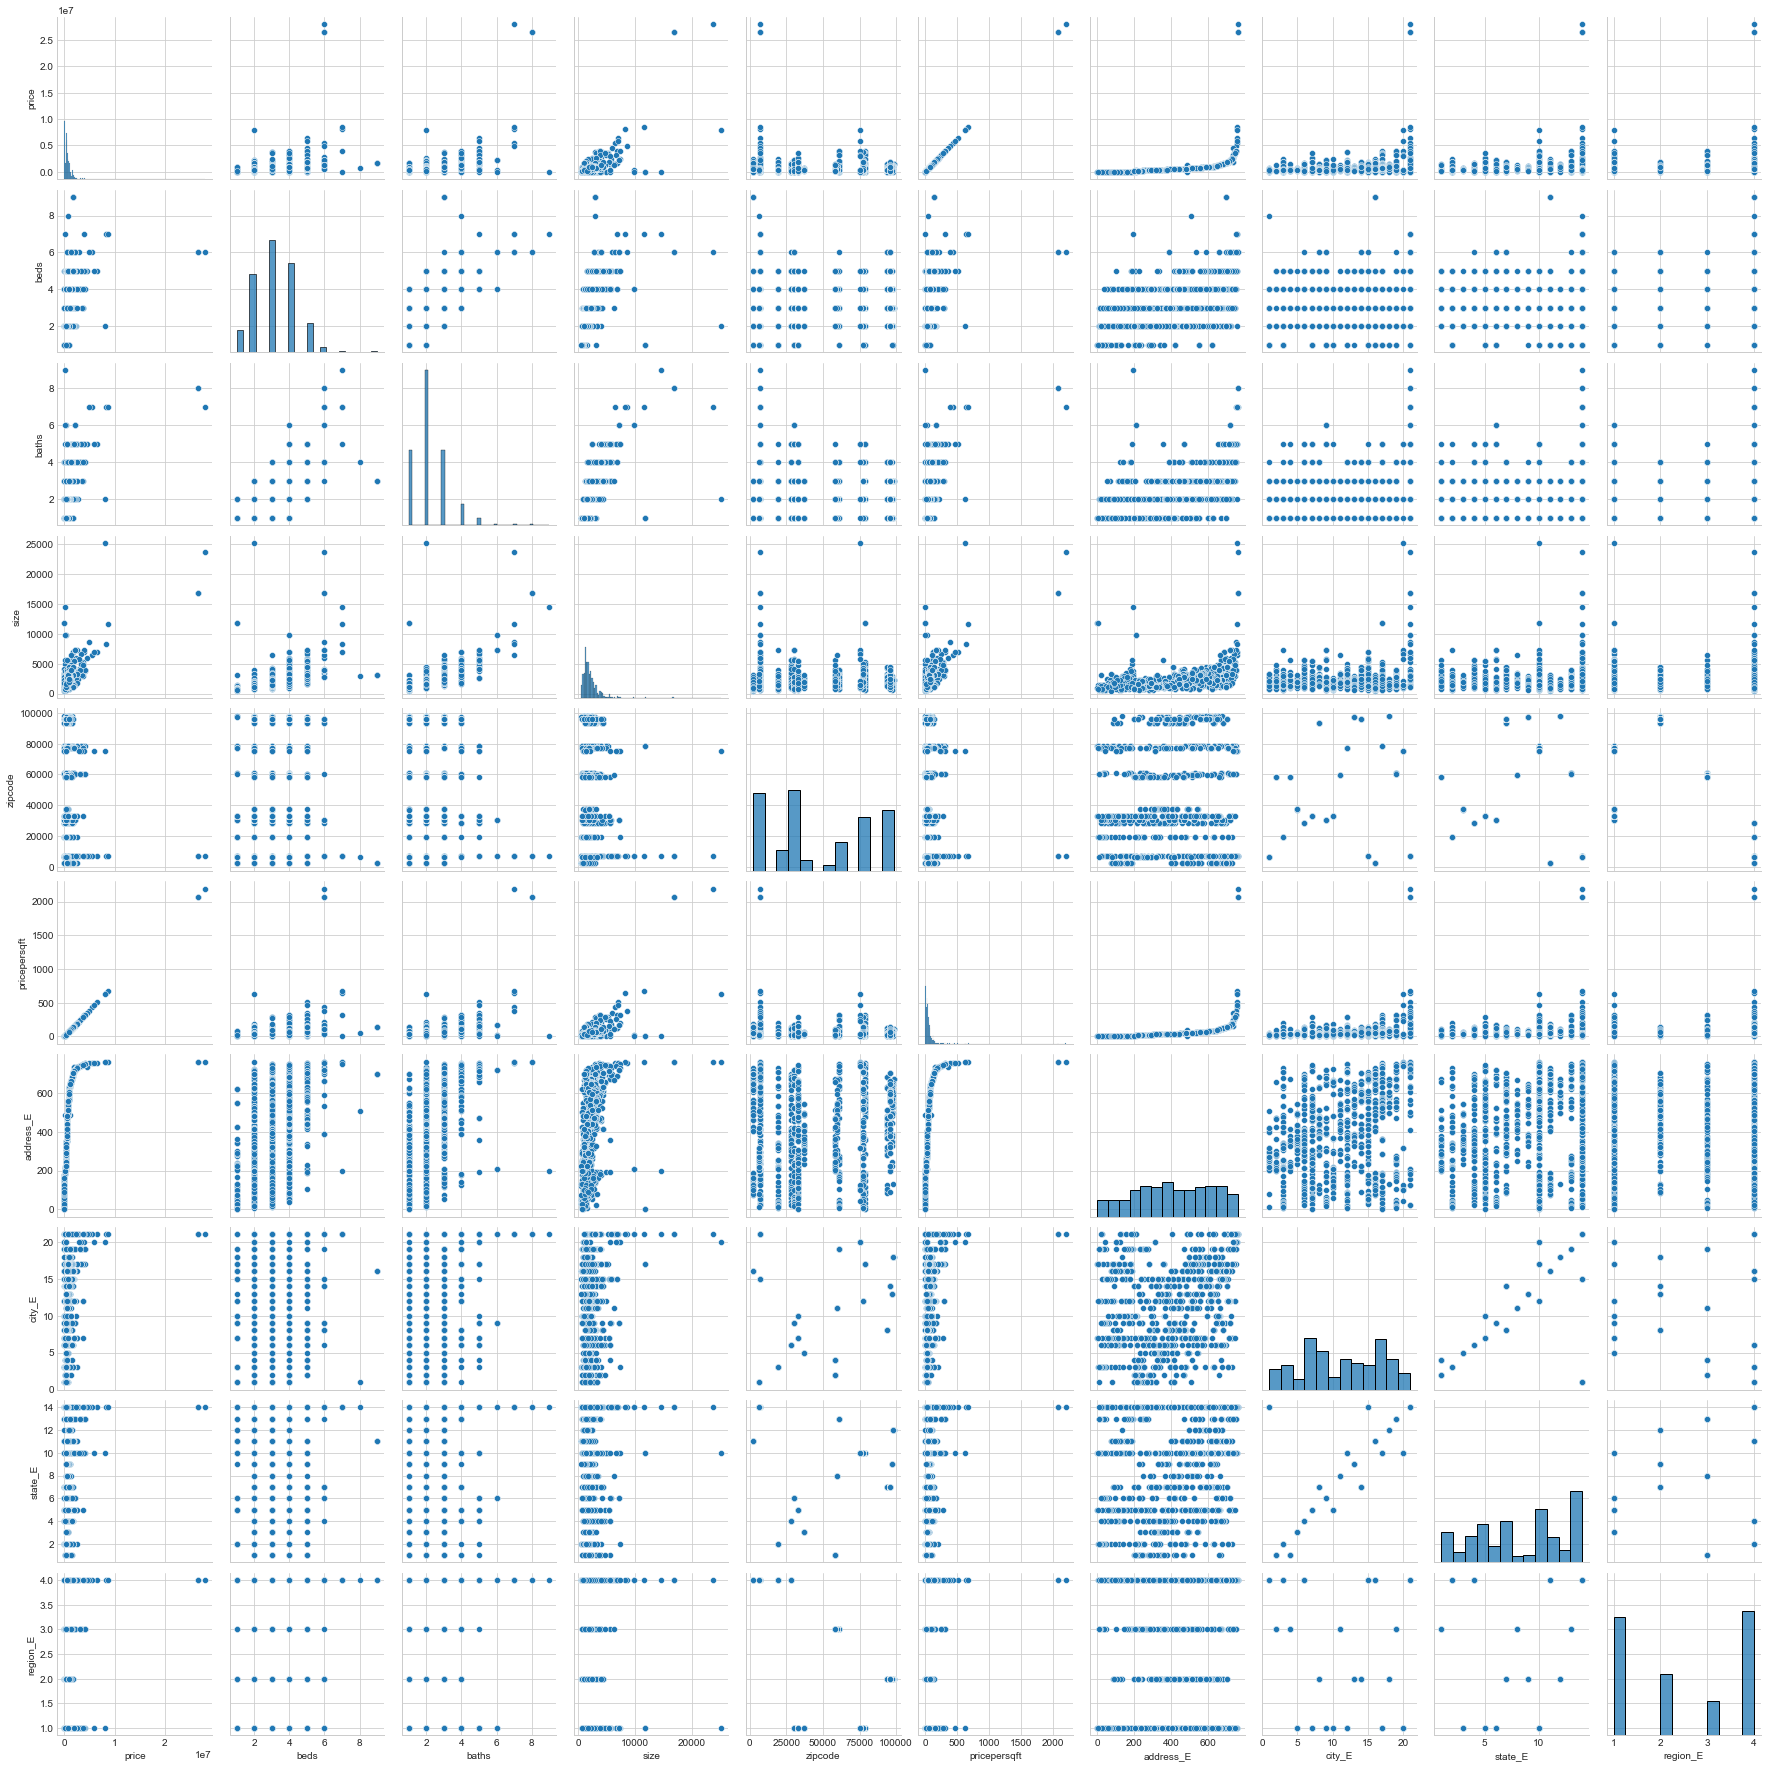

In [155]:
sns.pairplot(df4)

In [178]:
X = df4[['address_E', 'city_E', 'state_E','region_E',  'beds', 'baths','size']]

y = df4['price']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [180]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [181]:
lm.score(X_train,y_train)

0.558137806637672

In [182]:
lm.score(X_test,y_test)

0.4916196913286688

In [183]:
lm.score(X,y)

0.5382985820674919

In [184]:
print(lm.intercept_)

-1015233.0672633965


In [185]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
address_E,1808.332406
city_E,25178.246762
state_E,-21602.374350
region_E,85931.972598
beds,-189369.816127
baths,29581.169883
size,561.908393


In [186]:
predictions = lm.predict(X_test)

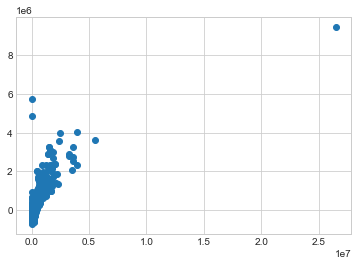

In [187]:
plt.scatter(y_test,predictions)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


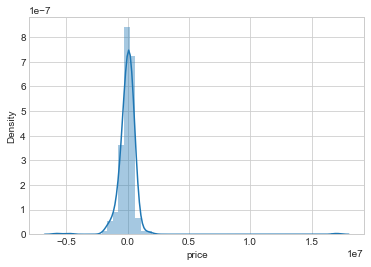

In [188]:
sns.distplot((y_test-predictions));

In [189]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 437357.7801797914
MSE: 1195682894679.7148
RMSE: 1093472.859599046


In [190]:
kf1 = KFold(n_splits=5, shuffle=True, random_state=42)

In [191]:
lm_cv = cross_val_score(lm, X_train, y_train, cv=kf1, scoring='r2')

print(lm_cv)

[ 0.56594748 -0.01530828 -0.69771644  0.26580853  0.48784637]


In [192]:
print(np.round(np.mean(lm_cv),3), "+-" , np.round(np.std(lm_cv),3))

0.121 +- 0.457


In [193]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

poly = PolynomialFeatures()

lm_poly = LinearRegression()
lm_poly.fit(poly.fit_transform(X_train), y_train)
y_pred = lm_poly.predict(poly.transform(X))
print("Polynomial Regression:", r2_score(y, y_pred))

Polynomial Regression: 0.899606667812516


In [194]:
y_pred = lm_poly.predict(poly.transform(X_test))
print("Polynomial Regression:", r2_score(y_test, y_pred))

Polynomial Regression: 0.8742542333783652


#### Try again on train, val, and test data

In [197]:
# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
                                        
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [200]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.6672576704390987

#### Let's see if polynomial regression can do better.

In [175]:

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

X_val_poly = poly.transform(X_val)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

0.9023538924173838

In [176]:
# Score on validation set
lr_poly.score(X_val_poly, y_val)

0.8410771178353478

In [177]:
lr_poly.coef_

array([ 0.00000000e+00, -5.49106962e+02, -2.21580044e+05,  2.25750321e+05,
       -1.26282189e+05, -1.05889140e+03,  1.54582053e+00,  5.10447339e+01,
       -9.02244598e+01,  1.96884097e+01,  1.06955867e+00,  4.52519426e+03,
       -7.24656522e+03,  4.01577789e+04,  2.93522720e+01,  3.73329397e+03,
       -5.67073916e+04, -9.72580716e+00,  7.93160747e+03,  2.75125503e+01,
        4.30295349e-02])

 This polynomial model gets a higher R2 score but seems to be a bit overfit. Let's try LassoCV, to a get a model that minimizes errors while keeping the model as simple as possible.

In [222]:
# setting up again:

X = df4.loc[:,['address_E', 'city_E', 'state_E','region_E',  'beds', 'baths','size']]

y = df4['price']

# create size squared term, which we expect to 
# help based on the relationship we see in the pair plot 
X['size2'] = X['size'] ** 2 

In [223]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address_E  1210 non-null   float64
 1   city_E     1210 non-null   float64
 2   state_E    1210 non-null   float64
 3   region_E   1210 non-null   float64
 4   beds       1210 non-null   int64  
 5   baths      1210 non-null   int64  
 6   size       1210 non-null   int64  
 7   size2      1210 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 75.8 KB


In [224]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [225]:
X_train.columns

Index(['address_E', 'city_E', 'state_E', 'region_E', 'beds', 'baths', 'size',
       'size2'],
      dtype='object')

In [226]:
X_train.shape

(726, 8)

In [227]:
X_val.shape

(242, 8)

In [228]:
X_test.shape

(242, 8)

In [229]:
selected_columns = ['address_E', 'city_E', 'state_E','region_E',  'beds', 'baths','size', 'size2']

In [231]:
lasso_model = Lasso(alpha = 1000000)
lasso_model.fit(X_train.loc[:,selected_columns], y_train)

Lasso(alpha=1000000)

In [232]:
list(zip(selected_columns, lasso_model.coef_))

[('address_E', 2881.0463919308045),
 ('city_E', 0.0),
 ('state_E', 0.0),
 ('region_E', 0.0),
 ('beds', 0.0),
 ('baths', 0.0),
 ('size', -318.40418911448984),
 ('size2', 0.06529752344925073)]

In [234]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train.loc[:,selected_columns], y_train)

list(zip(selected_columns, lr_model_ridge.coef_))

[('address_E', 0.06284585488155615),
 ('city_E', 0.0007077583501115256),
 ('state_E', 0.0003078425768927855),
 ('region_E', 4.302745714808943e-05),
 ('beds', 0.000113791823558524),
 ('baths', 0.00014730536157126314),
 ('size', 0.0027312467156343097),
 ('size2', 0.052343557546425876)]

In [235]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

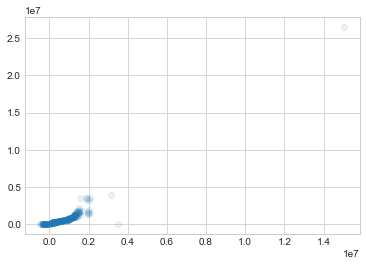

In [236]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))

In [237]:
#r-squared
r2_score(y_test, test_set_pred)

0.782733965768202

In [238]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

268084.4960842089

## Standard-scaling Features

In [247]:
## Scale the data
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [248]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [249]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [251]:
print('the best alpha value:' , lasso_model.alpha_)

the best alpha value: 100.0


In [253]:
#the standardized coefficients found
list(zip(X_train.columns, lasso_model.coef_))

[('address_E', 510092.7664431543),
 ('city_E', 17714.30017003658),
 ('state_E', 26564.916350663614),
 ('region_E', 59016.01274046909),
 ('beds', 15183.330735380328),
 ('baths', 300834.79578912415),
 ('size', -826275.6010253186),
 ('size2', 1792150.899967801)]

In [254]:

test_set_pred = lasso_model.predict(X_te)

In [255]:

mae(y_test, test_set_pred)

307515.19952457724

In [256]:
r2_score(y_test, test_set_pred)

0.7847769127129868

not much difference

 ### Visualization for all of the LASSO models across a range of different alpha values:

In [257]:
from sklearn.linear_model import lars_path

In [260]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


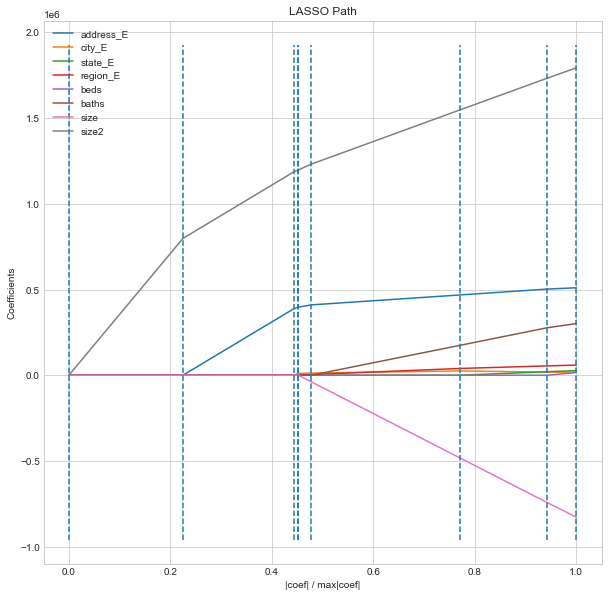

In [261]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

#### notes:
At the far left is the value of alpha where the penalty on coefficients is so onerous, that it just sets all of the coefficients to zero. At the far right is when there is no penalty, and corresponds to the values of the coefficients that you would get from a "vanilla" linear regression.
So each vertical slice corresponds to the coefficients you would get at a particular setting of alpha. The black dotted lines indicate where a new variable "enters" the model (that is, its coefficient changes from 0 to non-zero).
This is a good way to see which variables are most influential and how their strengths change as you change the value of alpha. Intuitively, the features that enter the model (nonzero coefficients) earliest in the path are the ones that the model treats as most essential, that it doesn't want to live without.